In [1]:

import torch 
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
import albumentations as A
#import albumentations
#from albumentations.pytorch.transforms import ToTensorV2
import matplotlib.pyplot as plt
import cv2
import time
import os
import copy
import os
from tqdm import tqdm

In [2]:
RANDOM_SEED = 786
def seed_everything(seed = RANDOM_SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [3]:
seed_everything()

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [6]:
from pathlib import Path
path = Path('/content/gdrive/My Drive/Assessments/Eluvio/temp/dataset_car_logo')
os.listdir(path)

['Test', 'Train']

In [7]:
train_dir = '/content/gdrive/My Drive/Assessments/Eluvio/temp/dataset_car_logo/Train'
test_dir = '/content/gdrive/My Drive/Assessments/Eluvio/temp/dataset_car_logo/Test'

In [9]:
labels = os.listdir(train_dir)
print(labels)

['Porsche', 'Ford', 'Lexus', 'Acura', 'MercedesBenz', 'Mazda', 'Hyundai', 'BMW', 'Volkswagen', 'Toyota', 'Honda', 'Audi', 'Nissan', 'Tesla', 'Chevrolet', 'Infiniti', 'Lamborghini', 'KIA']


In [10]:
label_dict = {label : i for i, label in enumerate(sorted(os.listdir(train_dir)))}
inv_label_dic = {i : label for i, label in enumerate(sorted(os.listdir(train_dir)))}

In [8]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [10]:
data_dir = '/content/gdrive/My Drive/Assessments/Eluvio/temp/dataset_car_logo'

In [9]:
train_dataset = datasets.ImageFolder(train_dir,data_transforms['train'])
test_dataset = datasets.ImageFolder(test_dir, data_transforms['val'])

In [10]:
bs = 4
train_loader = DataLoader(train_dataset, batch_size = bs, shuffle = True, num_workers = 2, pin_memory = True, drop_last= True)
test_loader = DataLoader(test_dataset, batch_size = bs, shuffle = True, num_workers = 2, pin_memory = True, drop_last= True)

In [11]:
class_names = train_dataset.classes

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


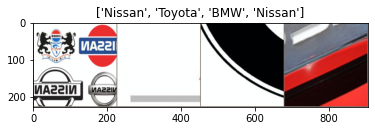

In [12]:
def show_batch(image, title):
  image = image.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  image = std * image + mean
  plt.imshow(image)
  if title:
    plt.title(title)
  plt.pause(0.001)

inputs, classes = next(iter(train_loader))
out = torchvision.utils.make_grid(inputs)

show_batch(out, title = [class_names[x] for x in classes])

In [14]:
pip install efficientnet_pytorch

In [15]:
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b3')

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b3-5fb5a3c3.pth


  0%|          | 0.00/47.1M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b3


In [16]:
num_ftrs = model._fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))
model= model.to(device)
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum = 0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
from sklearn.model_selection import train_test_split
#train_loader, val_loader = train_test_split(train_loader, test_size = 0.2)

In [21]:
# train for some number of epochs
epochs = 30
print_every = 1
for epoch in range(1, epochs + 1):
    train_loss = 0.0
    total_train = 0
    model.train()
    print(f'Training Model...')
    for image, labels in tqdm(train_loader):
        image = image.to(device)
        labels = labels.to(device)
        outputs = model(image)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * labels.shape[0]
        total_train += labels.shape[0]
    if epoch % 2 == 0:
        model.eval()
        val_loss = 0.0
        total_val = 0
        correct = 0
        print(f'Evaluating Model...')
        for image, labels in tqdm(test_loader):
            image = image.to(device)
            labels = labels.to(device)
            outputs = model(image)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            correct += (preds == labels).sum()
            total_val += labels.shape[0]
            val_loss = loss.item() * labels.shape[0]
        print('Validation Loss : {:.8f} || Accuracy : {:.3f}'.format((val_loss / total_val) , (correct / total_val) * 100))
        
    if epoch % print_every == 0:
        print(epoch)
        print('Train Loss : {:.3f}'.format((train_loss /total_train)))

Training Model...


100%|██████████| 212/212 [00:26<00:00,  8.07it/s]


1
Train Loss : 0.748
Training Model...


100%|██████████| 212/212 [00:27<00:00,  7.83it/s]


Evaluating Model...


100%|██████████| 26/26 [00:02<00:00, 12.77it/s]


Validation Loss : 0.12093898 || Accuracy : 52.885
2
Train Loss : 0.651
Training Model...


100%|██████████| 212/212 [00:27<00:00,  7.78it/s]


3
Train Loss : 0.723
Training Model...


100%|██████████| 212/212 [00:27<00:00,  7.75it/s]


Evaluating Model...


100%|██████████| 26/26 [00:02<00:00, 12.56it/s]


Validation Loss : 0.06051662 || Accuracy : 57.692
4
Train Loss : 0.637
Training Model...


100%|██████████| 212/212 [00:26<00:00,  7.91it/s]


5
Train Loss : 0.633
Training Model...


100%|██████████| 212/212 [00:26<00:00,  7.97it/s]


Evaluating Model...


100%|██████████| 26/26 [00:02<00:00, 12.34it/s]


Validation Loss : 0.07504864 || Accuracy : 57.692
6
Train Loss : 0.580
Training Model...


100%|██████████| 212/212 [00:26<00:00,  7.99it/s]


7
Train Loss : 0.564
Training Model...


100%|██████████| 212/212 [00:29<00:00,  7.12it/s]


Evaluating Model...


100%|██████████| 26/26 [00:02<00:00, 12.51it/s]


Validation Loss : 0.11495537 || Accuracy : 57.692
8
Train Loss : 0.476
Training Model...


100%|██████████| 212/212 [00:26<00:00,  7.92it/s]


9
Train Loss : 0.439
Training Model...


100%|██████████| 212/212 [00:26<00:00,  7.97it/s]


Evaluating Model...


100%|██████████| 26/26 [00:02<00:00, 12.30it/s]


Validation Loss : 0.09741695 || Accuracy : 57.692
10
Train Loss : 0.494
Training Model...


100%|██████████| 212/212 [00:26<00:00,  7.92it/s]


11
Train Loss : 0.437
Training Model...


100%|██████████| 212/212 [00:26<00:00,  7.93it/s]


Evaluating Model...


100%|██████████| 26/26 [00:02<00:00, 12.21it/s]


Validation Loss : 0.06774438 || Accuracy : 58.654
12
Train Loss : 0.435
Training Model...


100%|██████████| 212/212 [00:26<00:00,  7.98it/s]


13
Train Loss : 0.436
Training Model...


100%|██████████| 212/212 [00:27<00:00,  7.79it/s]


Evaluating Model...


100%|██████████| 26/26 [00:02<00:00, 11.98it/s]


Validation Loss : 0.04734443 || Accuracy : 58.654
14
Train Loss : 0.403
Training Model...


100%|██████████| 212/212 [00:26<00:00,  7.95it/s]


15
Train Loss : 0.427
Training Model...


100%|██████████| 212/212 [00:26<00:00,  8.02it/s]


Evaluating Model...


100%|██████████| 26/26 [00:02<00:00, 12.47it/s]


Validation Loss : 0.03589635 || Accuracy : 57.692
16
Train Loss : 0.416
Training Model...


100%|██████████| 212/212 [00:26<00:00,  7.93it/s]


17
Train Loss : 0.363
Training Model...


100%|██████████| 212/212 [00:26<00:00,  7.94it/s]


Evaluating Model...


100%|██████████| 26/26 [00:02<00:00, 12.04it/s]


Validation Loss : 0.05605697 || Accuracy : 56.731
18
Train Loss : 0.393
Training Model...


100%|██████████| 212/212 [00:26<00:00,  7.95it/s]


19
Train Loss : 0.313
Training Model...


100%|██████████| 212/212 [00:26<00:00,  7.96it/s]


Evaluating Model...


100%|██████████| 26/26 [00:02<00:00, 12.13it/s]


Validation Loss : 0.09280670 || Accuracy : 59.615
20
Train Loss : 0.313
Training Model...


100%|██████████| 212/212 [00:26<00:00,  7.95it/s]


21
Train Loss : 0.364
Training Model...


100%|██████████| 212/212 [00:26<00:00,  7.98it/s]


Evaluating Model...


100%|██████████| 26/26 [00:02<00:00, 12.29it/s]


Validation Loss : 0.16136859 || Accuracy : 64.423
22
Train Loss : 0.313
Training Model...


100%|██████████| 212/212 [00:26<00:00,  7.94it/s]


23
Train Loss : 0.397
Training Model...


100%|██████████| 212/212 [00:26<00:00,  7.91it/s]


Evaluating Model...


100%|██████████| 26/26 [00:02<00:00, 11.92it/s]


Validation Loss : 0.05427311 || Accuracy : 64.423
24
Train Loss : 0.333
Training Model...


100%|██████████| 212/212 [00:26<00:00,  7.93it/s]


25
Train Loss : 0.316
Training Model...


100%|██████████| 212/212 [00:26<00:00,  7.96it/s]


Evaluating Model...


100%|██████████| 26/26 [00:02<00:00, 11.72it/s]


Validation Loss : 0.06605098 || Accuracy : 60.577
26
Train Loss : 0.335
Training Model...


100%|██████████| 212/212 [00:27<00:00,  7.84it/s]


27
Train Loss : 0.274
Training Model...


100%|██████████| 212/212 [00:29<00:00,  7.19it/s]


Evaluating Model...


100%|██████████| 26/26 [00:02<00:00, 10.26it/s]


Validation Loss : 0.03543710 || Accuracy : 60.577
28
Train Loss : 0.338
Training Model...


100%|██████████| 212/212 [00:28<00:00,  7.48it/s]


29
Train Loss : 0.318
Training Model...


100%|██████████| 212/212 [00:26<00:00,  7.99it/s]


Evaluating Model...


100%|██████████| 26/26 [00:02<00:00, 12.53it/s]

Validation Loss : 0.01735322 || Accuracy : 62.500
30
Train Loss : 0.273


In [22]:
test_losses = []
model.eval()
num_correct = 0
for image, labels in tqdm(test_loader):
    image = image.to(device)
    labels = labels.to(device)
    outputs = model(image)
    _, preds = torch.max(outputs, 1)
    num_correct += torch.sum(preds == labels)
    loss = criterion(outputs, labels)
    test_losses.append(loss.item())
print("Test loss: {:.3f}".format(np.mean(test_losses)))
test_acc = num_correct/len(test_loader.dataset)
print("Test accuracy: {:.3f} %".format(test_acc * 100))
  

100%|██████████| 26/26 [00:02<00:00, 11.50it/s]

Test loss: 2.090
Test accuracy: 60.952 %


In [23]:
def visualize_model(model, num_images=12):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                show_batch(inputs.cpu().data[j], title = None)

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Source Pytorch Official Documents

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


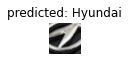

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


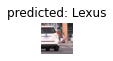

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


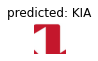

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


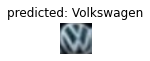

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


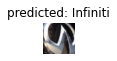

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


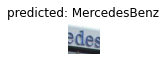

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


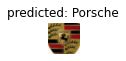

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


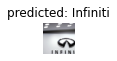

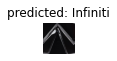

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


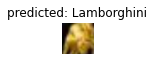

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


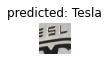

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


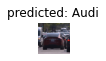

In [24]:
visualize_model(model)

In [29]:
torch.save(model.state_dict(), '/content/gdrive/My Drive/Assessments/Eluvio/efficientnet.pt')